### Bootcamp 2019 Day 5, Python *continued*

Mike Morais (4$^{th}$ year PNI, Pillow Lab)

---

Utilizing StackExchange, adapting starter code, and managing long multi-step analyses

# Neural decoding of location using hippocampal place cells (SOLUTIONS)

<img src="placecell.png" width=750>

Nancy Kanwisher's intro to place cells: ```https://youtu.be/km4203tZXnY?t=227```

<img src="encodedecode.png" width=700>

Simulating experiments can be a helpful way to ensure complicated analyses are working properly. If you're analyzing real data and the results look strange, is it because your code is wrong, or because your hypotheses are wrong? If you simulate data consistent with your hypotheses, then the only "free variable" is your analysis $-$ your results will be correct if and only if your code works as intended. This sort of piloting of your analyses would be a valuable asset in your future PhD work.

If you get truly stuck, I've imported functions from ```placecell_solutions.py``` that solve any of the steps of the analysis. I'll tell you which function you need, but it's your job to figure out how to use it! _Bonus points if you can code anything more cleverly than I did!_

$\longrightarrow$ _This problemset was based on Paul Miller's supplementary exercises from_ An Introductory Course in Computational Neuroscience. 

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from scipy import stats, integrate, interpolate
from scipy.signal import convolve2d
from scipy.optimize import minimize

import decoding_utils as utils
import decoding_solutions as sol

%matplotlib notebook
%autosave 100

%load_ext autoreload
## One approach to autoreload (more efficient, but AFAIK cannot rename the target packages)
# %aimport decoding_utils
# %aimport decoding_solutions
# %autoreload 1
## Other approach to autoreload (can slow down your code a bit, autoreloads everything)
%autoreload 2

np.random.seed(1)         # Initialize random number generator for reproducibility

Autosaving every 100 seconds
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 1 $-$ Visualizing place fields of sample hippocampal "neurons"

We will assume our simulated hippocampal "neurons" have place fields shaped like spherical Gaussians. This is a 2D version of the "bell curve" in our figure above. Our neurons will be defined by three parameters -- a center at which the firing rate of the neuron will be highest, a maximum firing rate; and a width with which that response will trail off away from that center.

Let's generate place fields for four neurons predefined below by these three parameters:

<IPython.core.display.Javascript object>


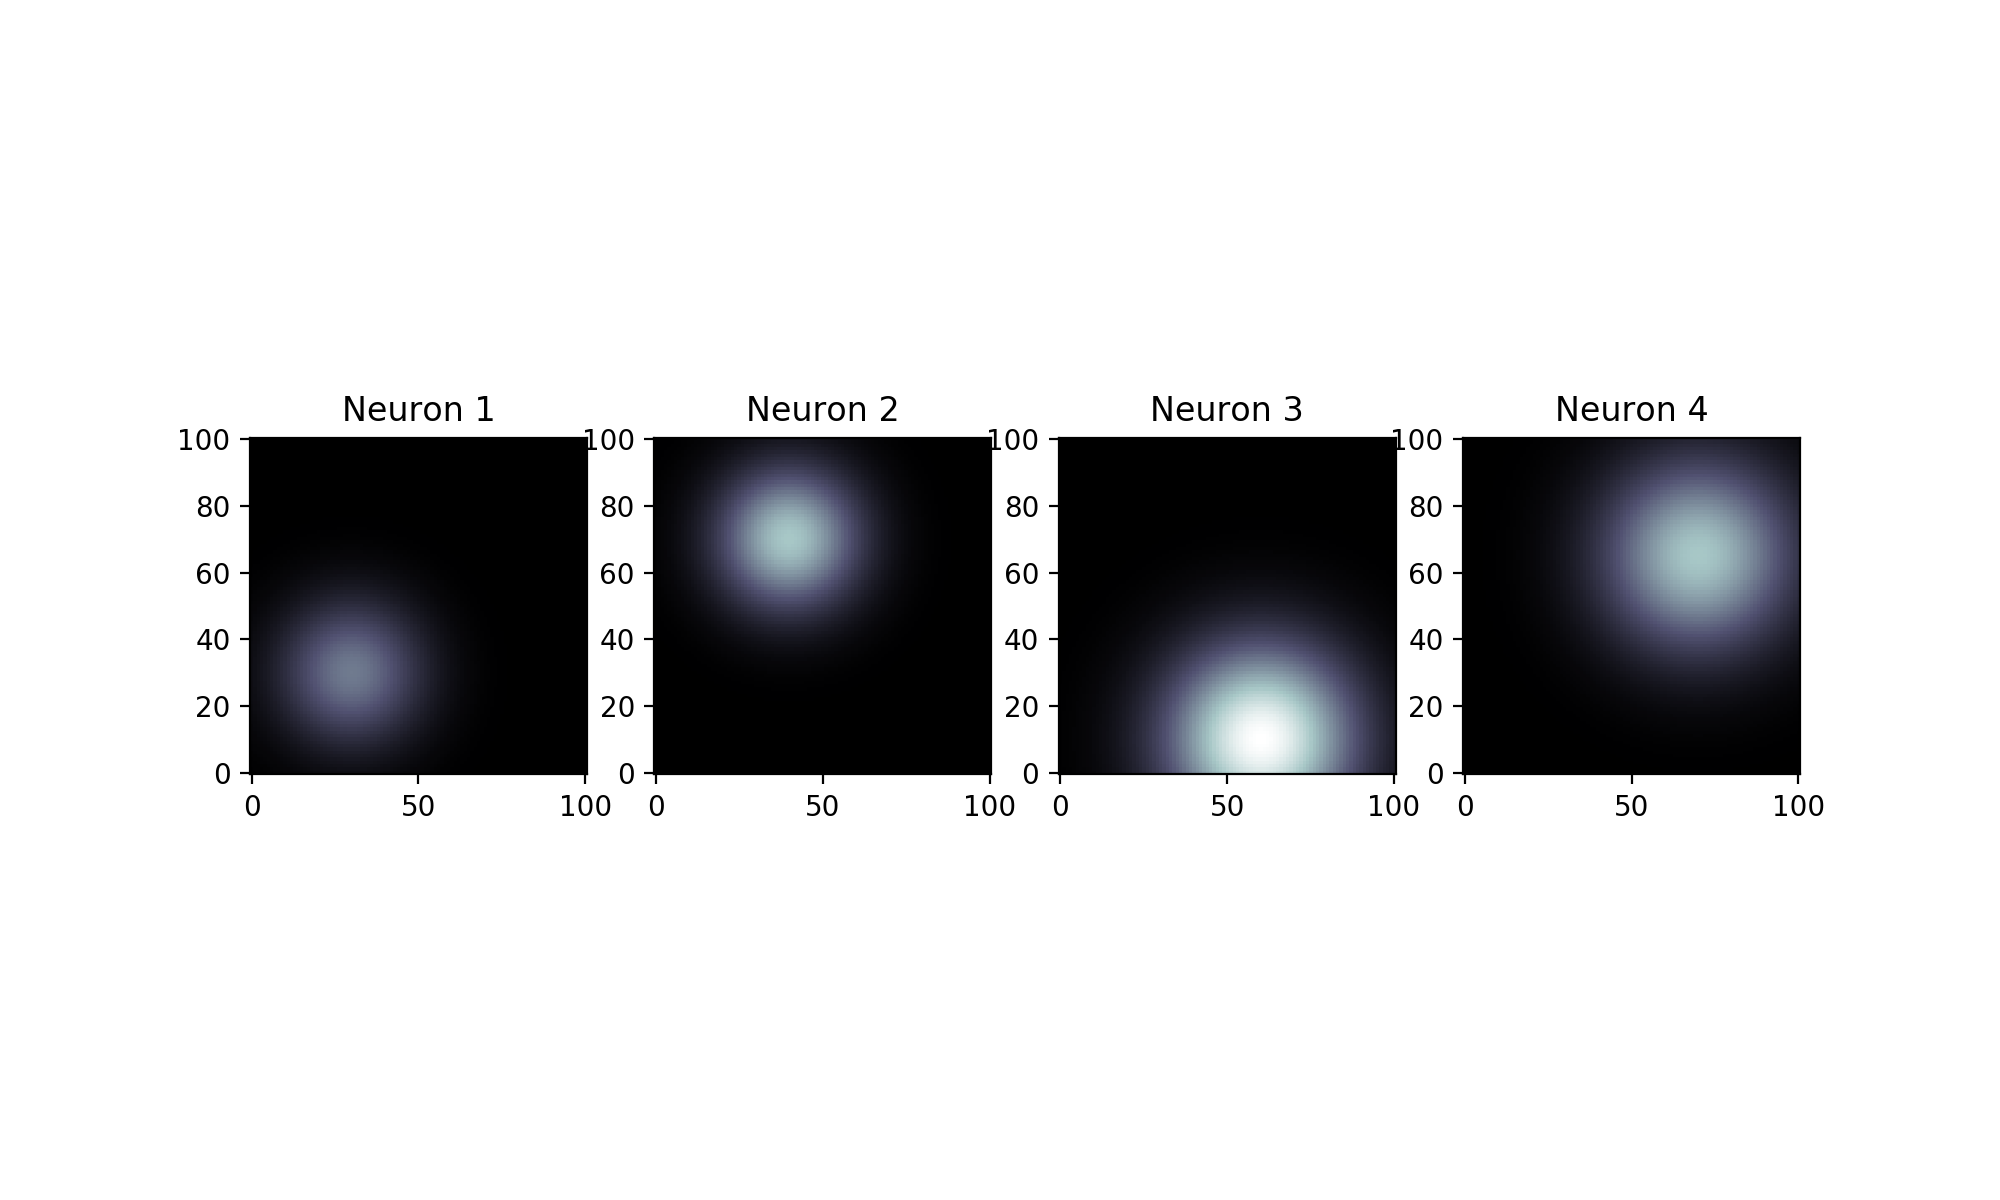

In [50]:
## Define the place fields of four cells (DETERMINISTIC)
N = 4
centers = np.array([[30, 30], [40, 70], [60, 10], [70, 65]]) ## (x,y)
widths = np.array([[15, 15, 20, 20]]).T                      ## Standard deviation of spherical Gaussians
rmax = np.array([[10, 15, 20, 15]]).T                        ## Maximum rate at center of place-field

## SOLUTION ----------------------------------------------------------------------------------------------------
## -------------------------------------------------------------------------------------------------------------

xx = np.arange(0,100+1) # Grid-points in the x-direction
yy = np.arange(0,100+1) # Grid-points in the y-direction
nx = xx.size            # Number of points in x-direction
ny = yy.size            # Number of points in y-direction

[xgrid, ygrid] = np.meshgrid(xx,yy); # In xgrid, each row is the same, and in ygrid, each col is the same

place_fields = sol.groundtruth_placefields(xgrid, ygrid, centers, widths, rmax)

plt.subplots(1,4, figsize=(10,6))
for cell in range(N):
    plt.subplot(1,4,1+cell)
    plt.imshow(place_fields[:,:,cell], cmap=plt.cm.bone, origin="lower")
    plt.title("Neuron %d" % (cell+1))
    plt.clim([0, np.max(rmax)])

## 2 $-$ ENCODING $-$ Simulating "animal" trajectory through the environment

We will assume our simulated animals walks through the 2D environment as a random walk. A random walk describes random motion in which the next step is independent of the one before it. Specifically, we want to simulate a random walk on a grid, which has nine possible moves _at each time increment_:

$$\nwarrow\quad\uparrow\quad\nearrow$$
$$\leftarrow\quad\circ\quad\rightarrow$$
$$\swarrow\quad\downarrow\quad\searrow$$

On a bounded grid, we want to have boundary conditions that prevent a move off the grid, e.g. on the rightmost edge of a grid, we'd only have these moves:

$$\nwarrow\quad\uparrow$$
$$\leftarrow\quad\circ$$
$$\swarrow\quad\downarrow$$

We moreover want to simulate neural responses along this random walk. Hippocampal place fields tell us what the (average) neural response will be at any given location. After we simulate the movement of the animal, we can measure what the average neural response should be of our hippocampal neurons. This is called the _neural code_ of that population. At each time step, each neuron may or may not spike, we only know what the spike rate should be _on average_, but fortunately this is enough to simulate the responses.

Given that this is a random walk with noisy neural responses, our solution should involve a lot of random numbers.

<IPython.core.display.Javascript object>


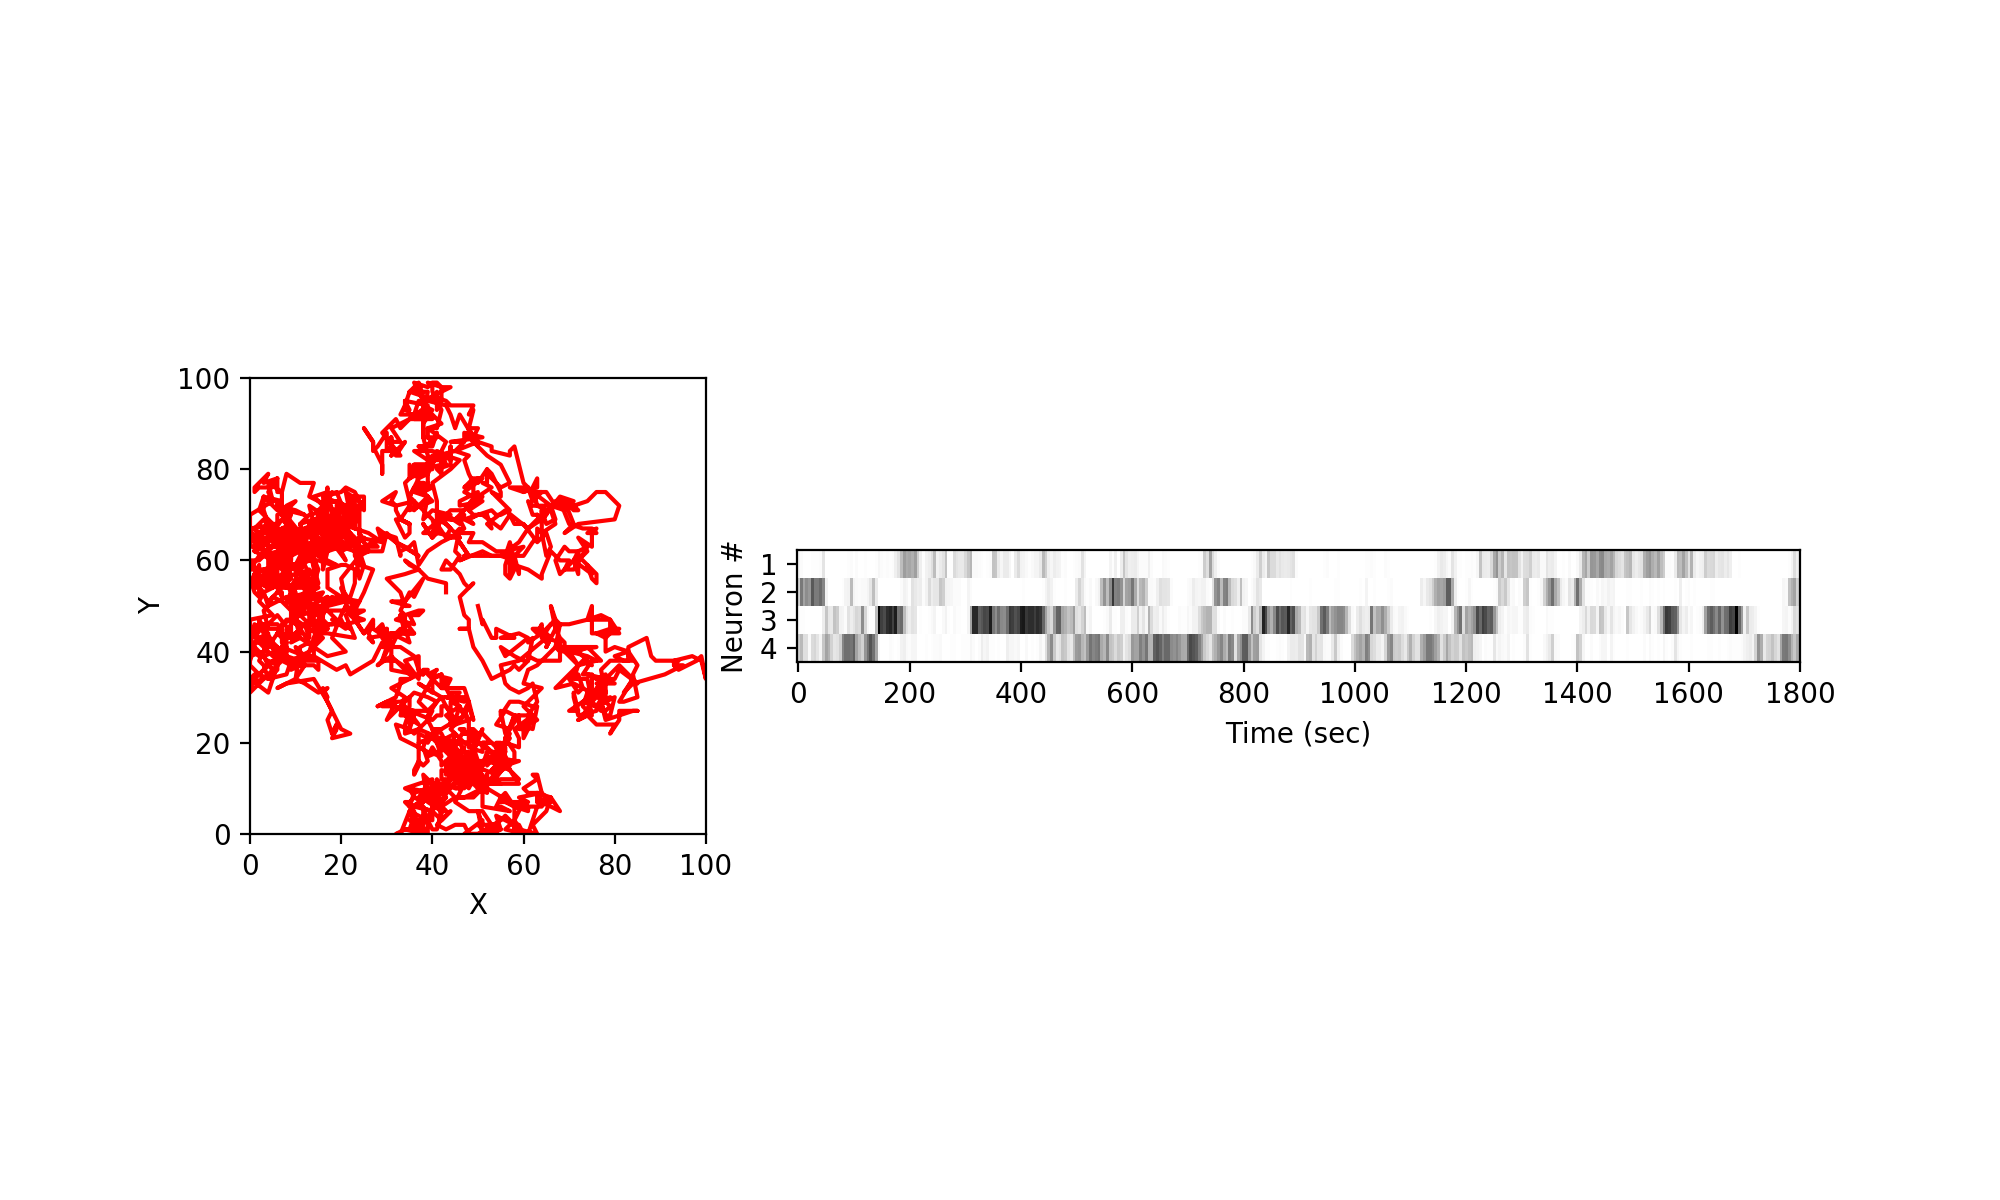

In [10]:
## SOLUTION ----------------------------------------------------------------------------------------------------
## -------------------------------------------------------------------------------------------------------------

## Generate a trajectory as a bounded random walk on a grid

dt = 0.02                   ## Size of time-bin
t = np.arange(0,1800,dt)    ## Vector of time-points
nt = t.size                 ## Number of time-points
thalf = int(nt/2)           ## Halfway point of timeseries (split for training/testing)

position, spikes = sol.spiking_randomwalk_grid(nt, dt, nx, ny, place_fields)

## Recast position as integers (we'll use them for indexing later)
position = np.array(position, dtype="int")

## Make plots of the trajectory and the resulting spike trains
plt.subplots(1,3, figsize=(10,6))
ax = plt.subplot(1,3,1)
plt.plot(position[:int(nt/4):10,0],position[:int(nt/4):10,1], c="r") ## Only half of the trajectory, every 10 samples
plt.xlabel("X"); plt.ylabel("Y")
ax.set_aspect("equal"); ax.set_xlim([xx[0],xx[-1]]); ax.set_ylim([yy[0],yy[-1]])
plt.subplot2grid((1,3), (0, 1), colspan=2)
rate = 250
ax = plt.imshow(utils.downsample_for_plot(spikes,rate), aspect=10, cmap=plt.cm.gist_yarg)
plt.xticks(np.linspace(0,nt/rate,10), np.linspace(0,nt*dt,10, dtype="int"));
plt.yticks(range(N),range(1,N+1));
plt.xlabel("Time (sec)"); plt.ylabel("Neuron #");

## 3 $-$ ANALYSIS $-$ Computing empirical spike fields and optimizing parametric functional fits

Now begins the data analysis stage, where experimental neuroscientists might actually start _in vivo_. Suppose the random walk and spike trains were the locations and neural responses of a real animal, and that we _didn't_ know the true place fields. We want to estimate them from these data. Where do we start?

Every time a spike occurs, we can know _where_ the animal was when it occurred. Intuitively, a general location that ellicits more spikes is more likely to be near the center of the place field. So if we want to estimate the place field for each neuron, we can start by computing for each a _spike field_, which counts spikes at each location in the grid and reports the proportion of the time a neuron spikes at each location.

The resulting spike field is very chunky and noisy, but we assume that place fields should be generally smooth. To finish, we'll fit a smooth function to these spike fields and use these in our downstream analyses.



In [29]:
## SOLUTION ----------------------------------------------------------------------------------------------------
## -------------------------------------------------------------------------------------------------------------

# WE COULD CALL THIS, BUT IT'S BETTER TO BURY THIS FUNCTION IN THE FOLLOWING ONE... Take a look.
# spike_fields, prob_spike, prob_loc, xyhist = sol.estimate_spikefields(position, spikes, xgrid, ygrid)

## 4 $-$ ANALYSIS $-$ Estimating place fields

The spike fields we've estimated are actually a (posterior) probability of spiking at each location -- not a place field. Hopefully it's clear, though, that these two things should be related. A neuron that spikes with consistently higher probability should have a higher firing rate, so conversion from spike field to place field is reasonably straightforward. **Don't worry about the underlying details too much, the methods themselves are pretty quick.**

We can estimate the placefields using a (re)normalization in the following way:
$$\textsf{PlaceField}(\text{location}) = \frac{\textsf{SpikeField}(\text{location})\Pr[\text{spike}]}{ Z\cdot\Delta t\cdot \Pr[\text{location}]}$$
where $Z$ is the sum total of all probabilities in the spike field.

<IPython.core.display.Javascript object>


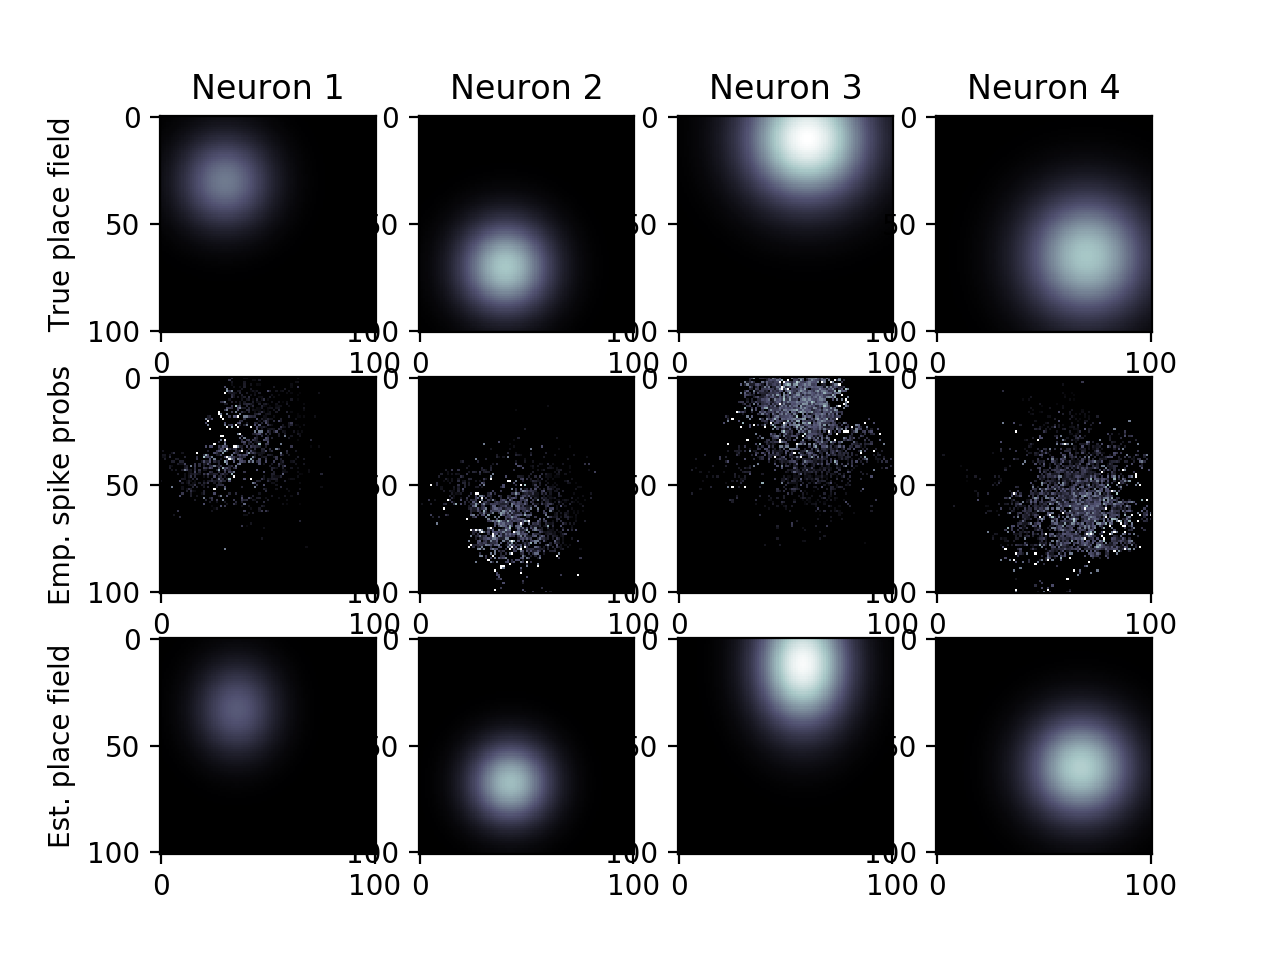

In [33]:
## SOLUTION ----------------------------------------------------------------------------------------------------
## -------------------------------------------------------------------------------------------------------------

spike_fields, est_place_fields, xyhist = sol.estimate_placefields(position, spikes, dt, xgrid, ygrid)

## Plotting the fits
nsub = np.minimum(4,N)
plt.subplots(3,nsub) ## If using more than 4 neurons, only plot 4
for cell in range(nsub):
    plt.subplot(3,nsub,0*nsub+1+cell)
    plt.imshow(place_fields[:,:,cell], cmap=plt.cm.bone)
    plt.title("Neuron %d" % (cell+1))
    plt.clim([0, np.max(rmax)])
    if cell == 0:
        plt.ylabel("True place field")
    plt.subplot(3,nsub,1*nsub+1+cell)
    plt.imshow(xyhist[:,:,cell], cmap=plt.cm.bone)
    if cell == 0:
        plt.ylabel("Emp. spike probs")
    plt.subplot(3,nsub,2*nsub+1+cell)
    plt.imshow(est_place_fields[:,:,cell], cmap=plt.cm.bone)
    if cell == 0:
        plt.ylabel("Est. place field")
    plt.clim([0, np.max(rmax)])

## 5 $-$ DECODING $-$  Decoding position from estimated place fields

Our analysis of place cell encoding used positions and spikes to estimate the place fields. With those place field estimates, we can start our analysis of decoding to estimate the position. _Why bother re-estimating position when we have it already?_ If our model is correct, and our assumptions are valid, our decoding should be a faithful reconstruction of the data. As a result, "decoding" analyses are ubiquitous throughout neuroscience.

In this case of hippocampal neurons, strong decoding means our place cells do in fact represent meaningful location information. To decode, we'll leverage an iterative procedure called Bayesian updating. Importantly, this means that we're making location estimates _with uncertainty_, so we're actually estimating probabilities that the animal is in any location. Suppose we have estimates for some time $t$, and want to estimate time $t+1$. There are two sources of updated information at play here:

1. What is the probability that we'll be at location $(x^*,y^*)$ at time $t+1$? It's the probability that we were at location $(x^*-1,y^*)$ previously and moved right, plus the probability that we were at location $(x^*+1,y^*)$ previously and moved left, and so on. Using our assumption of a random walk, we know that we can update each location's probability using the nine possible movements that arrive at that location, and repeat this procedure for each location.

2. Suppose on time $t+1$, neurons $1$ and $2$ spiked, but neurons $3$ and $4$ didn't. Then the movement is likely to be "towards" the place fields of the neurons that spiked and "away from" the place fields of the neurons that spiked. This can be done by multiplying our estimate by the spike field (or the "no-spike" field) of each spiking (or not-spiking) neuron.

At every time step, we can _update_ our estimate of the animal's location for the next time step, and repeat.

In [46]:
## SOLUTION ----------------------------------------------------------------------------------------------------
## -------------------------------------------------------------------------------------------------------------

xyest = sol.decode(xx, yy, position, spikes, spike_fields, plot_flag=True)

score, MSE = sol.compute_scores(xyest, position[thalf:,:])
print("Correlation score: %.4f\nMSE: %.4f" % (score,MSE))

Correlation score: 0.9605
MSE: 121.2673


## 6 $-$ Plotting

<IPython.core.display.Javascript object>


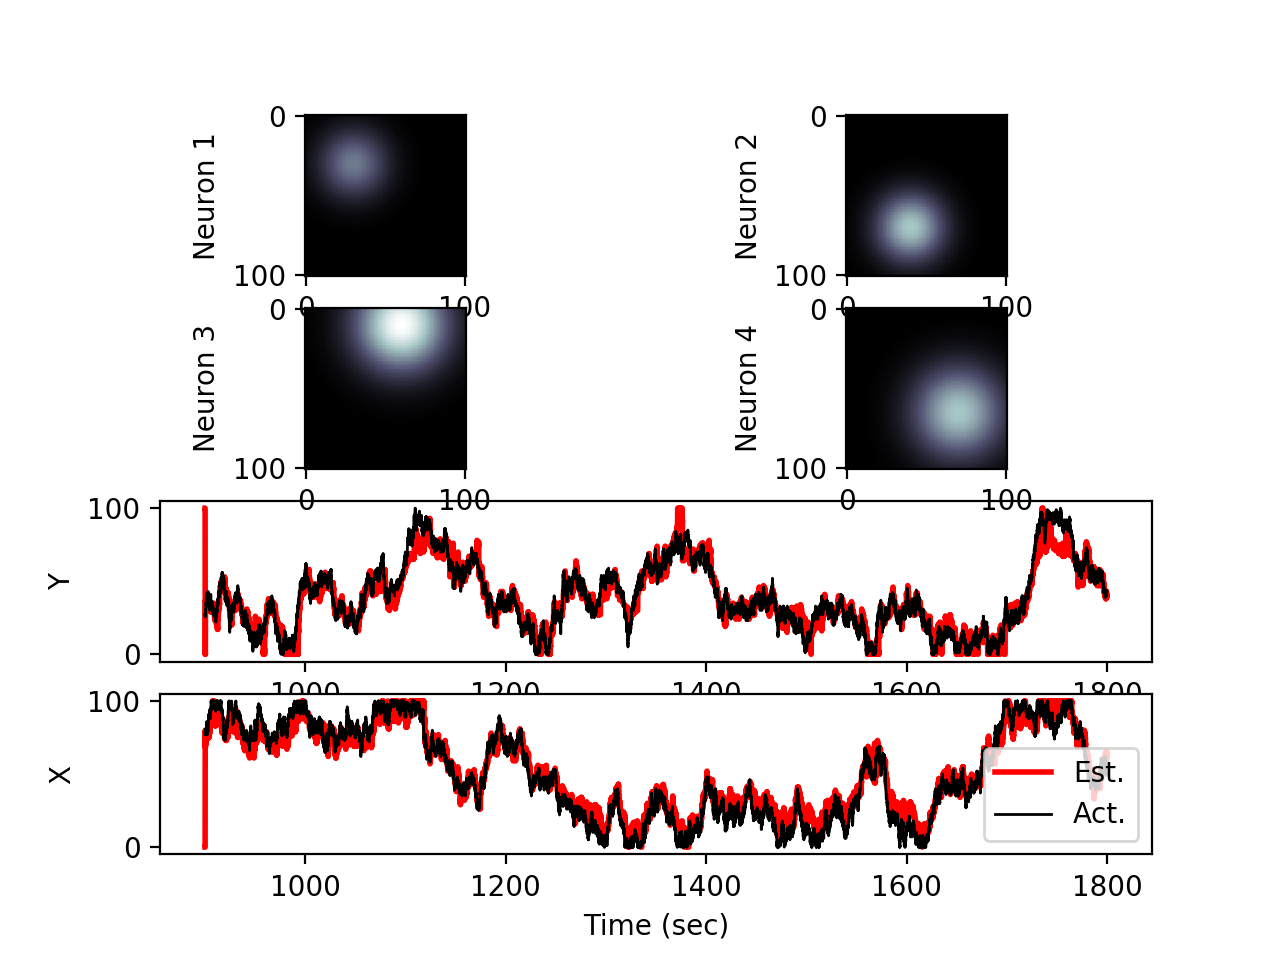

In [49]:
## Plot the decoded estimates to see how well they track the actual coordinates
fig = plt.figure()
figsz = (4, 2)

plt.subplot2grid(figsz, (2, 0), colspan = 2)
plt.plot(t[thalf:], xyest[:,0], '-r', lw = 2)
plt.plot(t[thalf:], position[thalf:,0], '-k', lw = 1)
# plt.legend(("Est.","Act."))
plt.ylabel('Y')
plt.xlabel('Time (sec)')

plt.subplot2grid(figsz, (3, 0), colspan=2)
plt.plot(t[thalf:], xyest[:,1], '-r', lw = 2)
plt.plot(t[thalf:], position[thalf:,1], '-k', lw = 1)
plt.legend(("Est.","Act."), loc="lower right")
plt.ylabel('X')
plt.xlabel('Time (sec)')

for cell in range(4):
    plt.subplot(4,2,1+cell)
    plt.imshow(place_fields[:,:,cell], cmap=plt.cm.bone)
    plt.ylabel("Neuron %d" % (cell+1))
    plt.clim([0, np.max(rmax)])

## 7 $-$ Analysis with larger "neural" populations (Challenge)

Generalize the whole pipeline for random populations of different numbers of neurons. Can you find any features of your simulated populations that predict better or worse decoding, e.g. number of neurons, separation of placefield centers, high or low placefield widths? 

This could be a great opportunity to abstract your previous code into functions, and make sure its as flexible as necessary.